In [122]:
cd /home

/home


In [123]:
import matplotlib.pyplot as plt
import tensorflow as tf
import pandas as pd
import numpy as np
import os
import sys,os

os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

from src.data import pretraining_pipeline, create_dataset

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [124]:
name                 = 'atlas'
lightcurves_folder   = f'./data/raw_data/{name}/LCs/' # lightcurves folder
lightcurves_metadata = f'./data/raw_data/{name}/metadata.csv' # metadata file
fold_to_save_records = './data/records_new'

In [126]:
meta = pd.read_csv(lightcurves_metadata)
# meta = meta[meta['Class'] != 'UNK']
# meta = meta[meta['Class'] != 'std']
# meta = meta[meta['Class'] != 'Dubious']

meta['Band'] = tf.ones(meta.shape[0])
meta = meta.rename(columns={'objID':'ID', 'Unnamed: 0':'ID', 'Path_R':'Path'})
print(meta.shape)
if 'atlas' in name:
    meta['Path'] = meta['ID'].astype(str)+'.dat'
    
print(meta['Class'].value_counts())

(4719921, 6)
Dubious    4294188
Other       283709
CB           80368
DB           28895
Pulse        25140
Mira          7621
Name: Class, dtype: int64


## One sample visualization

In [128]:
args = {
    'alcock':{},
    'ogle': {'names':['mjd', 'mag', 'errmag'], 'delim_whitespace':True},
    'atlas': {'names':['mjd', 'mag', 'errmag'],'delim_whitespace':False, 'skiprows':1}
}

[INFO] Reading: 151823040192305135.dat


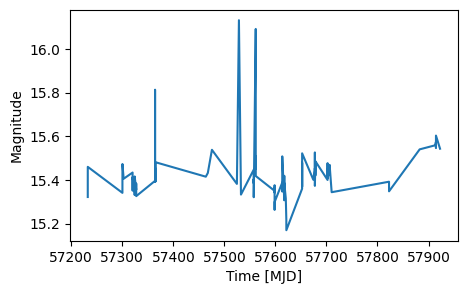

In [129]:
sample = meta.sample()['Path'].values[0].split('/')[-1]
print(f'[INFO] Reading: {sample}')
lc_sample = pd.read_csv(f'{lightcurves_folder}/{sample}', **args[name])
plt.figure(figsize=(5,3))
plt.plot(lc_sample['mjd'], lc_sample['mag'])
plt.xlabel('Time [MJD]')
plt.ylabel('Magnitude')
plt.show()

## Pretraining data

In [131]:
target = f'{fold_to_save_records}/{name}_pt'

In [135]:
meta_filtered = meta[meta['N'] > 100]

In [ ]:
create_dataset(meta_filtered, 
               lightcurves_folder, 
               target, 
               max_lcs_per_record=20000, 
               n_jobs=16, # depends on the number of cores 
               subsets_frac=(0.6, 0.2), 
               **args[name])

 33%|███████████████████▎                                      | 2/6 [00:42<01:18, 19.63s/it]

## Creating folds

In [130]:
n_folds = 3
samples_per_class_test = 100
samples_per_class = [20, 50, 100, 500]

In [120]:
%%time

for fold_n in range(n_folds): 
    test_meta  = pd.concat([frame.sample(n=samples_per_class_test) for g, frame in meta.groupby('Class')])
    train_meta = meta[~meta['ID'].isin(test_meta['ID'])]
    print(test_meta.shape, train_meta.shape)
        
    for nsamples in samples_per_class:  
        if nsamples == 0:
            partial_meta = train_meta
            target = f'{fold_to_save_records}/{name}/fold_{fold_n}/{name}'
        else:
            partial_meta = pd.concat([frame.sample(n=nsamples) for c, frame in train_meta.groupby('Class')])
            target = f'{fold_to_save_records}/{name}/fold_{fold_n}/{name}_{nsamples}'

        create_dataset(partial_meta, lightcurves_folder, 
                       target, max_lcs_per_record=20000, 
                       n_jobs=7, subsets_frac=(0.8, 0.2), test_subset=test_meta,  
                       **args[name])

(1000, 5) (357288, 5)


100%|████████████████████████████████████████████████████████| 10/10 [00:07<00:00,  1.28it/s]


(1000, 5) (357288, 5)


100%|████████████████████████████████████████████████████████| 10/10 [00:07<00:00,  1.28it/s]


(1000, 5) (357288, 5)


100%|████████████████████████████████████████████████████████| 10/10 [00:07<00:00,  1.28it/s]

CPU times: user 53.1 s, sys: 1.28 s, total: 54.4 s
Wall time: 57.7 s


# Reading folds

In [121]:
for fold_n in range(3):
    for nsamples in samples_per_class:
        if nsamples == 0:
            partial_meta = train_meta
            target = f'{fold_to_save_records}/{name}/fold_{fold_n}/{name}'
        else:
            partial_meta = pd.concat([frame.sample(n=nsamples) for c, frame in train_meta.groupby('Class')])
            target = f'{fold_to_save_records}/{name}/fold_{fold_n}/{name}_{nsamples}'
        
        n_classes = pd.read_csv(os.path.join(target, 'objects.csv'))
#         print(n_classes)
        n_classes = n_classes.shape[0]
        dataset = pretraining_pipeline(os.path.join(target, 'test'),
                                       batch_size=16,
                                       msk_frac=0., rnd_frac=0., same_frac=0., 
                                        
                                       num_cls=n_classes, return_ids=True)
        labels = np.concatenate([np.argmax(y, 1) for _, y in dataset], 0)
        unique, counts = np.unique(labels, return_counts=True)
        
        oids = np.concatenate([x['ids'] for x, _ in dataset], 0)
        
        unique_id, counts_id = np.unique(oids, return_counts=True)
#         print(counts_id)
        print(unique)
        print(counts)
#         print('-')

[INFO] Repeating dataset x1 times
[0 1 2 3 4 5 6 7 8 9]
[100 100 100 100 100 100 100 100 100 100]
[INFO] Repeating dataset x1 times
[0 1 2 3 4 5 6 7 8 9]
[100 100 100 100 100 100 100 100 100 100]
[INFO] Repeating dataset x1 times
[0 1 2 3 4 5 6 7 8 9]
[100 100 100 100 100 100 100 100 100 100]
[INFO] Repeating dataset x1 times
[0 1 2 3 4 5 6 7 8 9]
[100 100 100 100 100 100 100 100 100 100]
[INFO] Repeating dataset x1 times
[0 1 2 3 4 5 6 7 8 9]
[100 100 100 100 100 100 100 100 100 100]
[INFO] Repeating dataset x1 times
[0 1 2 3 4 5 6 7 8 9]
[100 100 100 100 100 100 100 100 100 100]
[INFO] Repeating dataset x1 times
[0 1 2 3 4 5 6 7 8 9]
[100 100 100 100 100 100 100 100 100 100]
[INFO] Repeating dataset x1 times
[0 1 2 3 4 5 6 7 8 9]
[100 100 100 100 100 100 100 100 100 100]
[INFO] Repeating dataset x1 times
[0 1 2 3 4 5 6 7 8 9]
[100 100 100 100 100 100 100 100 100 100]
[INFO] Repeating dataset x1 times
[0 1 2 3 4 5 6 7 8 9]
[100 100 100 100 100 100 100 100 100 100]
[INFO] Repeating dat